# Voltage Clamp Simulation

### Importing Libraries

In [1]:
import scipy as sp
import numpy as np
import pylab as plt
from scipy.integrate import odeint

In [2]:
# Initializing parameters

Cm = 1            # Membrane capacitance, in uF/cm^2
gmax_Na = 120      # Sodium (Na) maximum conductances, in mS/cm^2
gmax_K = 36        # Potassium (K) maximum conductances, in mS/cm^2
gmax_L = 0.3       # Leak maximum conductances, in mS/cm^2


VNa = 115.0         # Sodium (Na) Nernst reversal potentials, in mV
VK = -12.0          # Potassium (K) Nernst reversal potentials, in mV
VL = 10.613      # Leak Nernst reversal potentials, in mV

<img src="images/vclamp/alphabeta.png">

In [3]:
alpha_n = lambda Vm: (0.01 * (10.0 - Vm)) / (np.exp((10 - Vm)/10) - 1.0)
beta_n = lambda Vm: 0.125 * np.exp(-Vm / 80.0)

alpha_m = lambda Vm: (0.1 * (25.0 - Vm)) / (np.exp((25 - Vm)/10) - 1.0)
beta_m = lambda Vm: 4.0 * np.exp(-Vm / 18.0)

alpha_h = lambda Vm: 0.07 * np.exp(-Vm / 20.0)
beta_h = lambda Vm: 1.0 / (np.exp((30 - Vm)/10) + 1.0)

<img src="images/vclamp/gnaka.png">

In [4]:
# Conductance density (in mS/cm^2) of Sodium and Potassium
gNa =  lambda m, h : gmax_Na * m**3 * h 
gK  =  lambda n    : gmax_K  * n**4

<img src="images/vclamp/jall.png">

In [5]:
#_Na(m, h) * (V - self.E_Na)
JNa = lambda Vm, m, h : gNa(m, h)   *  (Vm - VNa)
JK =  lambda Vm, n    : gK(n)       *  (Vm - VK)
JL =  lambda Vm       : gmax_L      *  (Vm - VL)

In [6]:
def n_inf(Vm= 0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

<img src="images/vclamp/dall.png">

In [7]:
# ODE system
def dALLdt(X, t):
    V, m, h, n = X
    dVdt = (I_inj_iclamp(t) - JNa(V, m, h) - JK(V, n) - JL(V)) / Cm
    dmdt = alpha_m(V)*(1.0-m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dmdt, dhdt, dndt

## You can try changing values here

In [17]:
# Current clamp parameters
I_amp   = 10       # Maximum value or amplitude of injection pulse
I_dur   = 10      # Duration or width of injection pulse
I_delay = 10      # Start time of injection pulse

# Defining current clamp current injection
def I_inj_iclamp(t):
    return I_amp * (t > I_delay) - I_amp * (t > I_delay + I_dur)

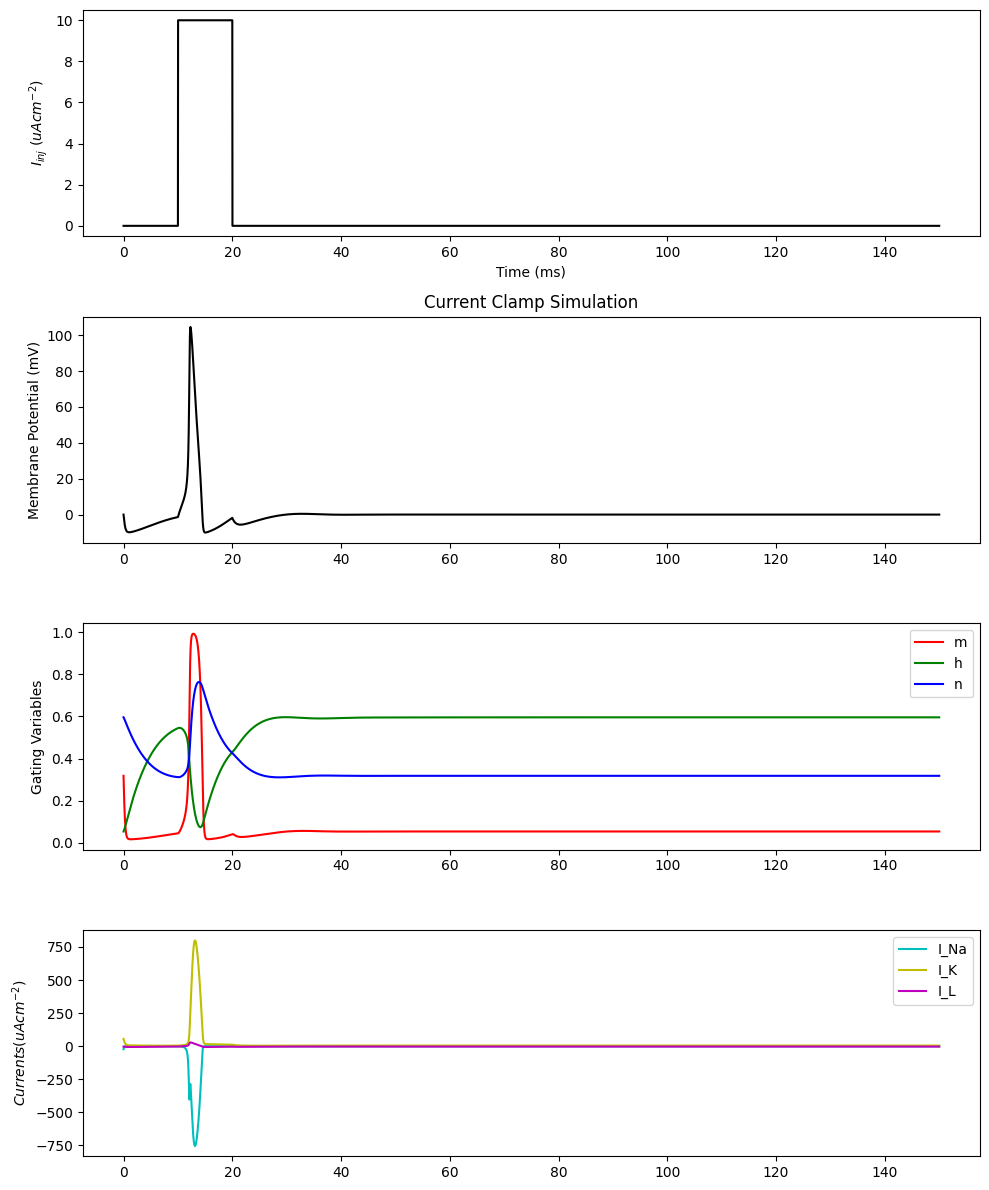

In [18]:

gNa =  lambda m, h : gmax_Na * m**3 * h 
gK  =  lambda n    : gmax_K  * n**4
def simulate_iclamp(t_n = 150, delta_t = 0.01):
    t    =   np.arange(0, t_n, delta_t)
    init_values = [0.0, n_inf(), m_inf(), h_inf()]
    X     =   odeint(dALLdt, init_values, t)
    V     =   X[:, 0]
    mn    =   X[:, 1]
    hn    =   X[:, 2]
    nn    =   X[:, 3]
    ina   =   JNa(V, mn, hn)
    ik    =   JK(V, nn)
    il    =   JL(V)
    
    # Plotting results
    plt.figure(figsize=(10, 12))

    # Injected current
    plt.subplot(4, 1, 1)
    i_inj_values = [I_inj_iclamp(time) for time in t]
    plt.plot(t, i_inj_values, 'k')
    plt.ylabel('$I_{inj}$ $(uA cm^{-2})$')
    plt.xlabel('Time (ms)')
    
    # Membrane potential
    plt.subplot(4, 1, 2)
    plt.plot(t, V, 'k')
    plt.title('Current Clamp Simulation')
    plt.ylabel('Membrane Potential (mV)')

    # Gating variables
    plt.subplot(4, 1, 3)
    plt.plot(t, mn, 'r', label='m')
    plt.plot(t, hn, 'g', label='h')
    plt.plot(t, nn, 'b', label='n')
    plt.ylabel('Gating Variables')
    plt.legend()

    # Currents
    plt.subplot(4, 1, 4)
    plt.plot(t, ina, 'c', label='I_Na')
    plt.plot(t, ik, 'y', label='I_K')
    plt.plot(t, il, 'm', label='I_L')
    plt.ylabel('$Currents ( uA cm^{-2})$')
    plt.legend()
    

    plt.tight_layout()
    plt.show()

# Run current clamp simulation
simulate_iclamp()